# Supervised graph classification with GCN


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/graph-classification/gcn-supervised-graph-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/graph-classification/gcn-supervised-graph-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This notebook demonstrates how to train a graph classification model in a supervised setting using graph convolutional layers followed by a mean pooling layer as well as any number of fully connected layers.

The graph convolutional classification model architecture is based on the one proposed in [1] (see Figure 5 in [1]) using the graph convolutional layers from [2]. This demo differs from [1] in the dataset, MUTAG, used here; MUTAG is a collection of static graphs representing chemical compounds with each graph associated with a binary label. Furthermore, none of the graph convolutional layers in our model utilise an attention head as proposed in [1].

Evaluation data for graph kernel-based approaches shown in the very last cell in this notebook are taken from [3].

**References**

[1] Fake News Detection on Social Media using Geometric Deep Learning, F. Monti, F. Frasca, D. Eynard, D. Mannion, and M. M. Bronstein, ICLR 2019. ([link](https://arxiv.org/abs/1902.06673))

[2] Semi-supervised Classification with Graph Convolutional Networks, T. N. Kipf and M. Welling, ICLR 2017. ([link](https://arxiv.org/abs/1609.02907))

[3] An End-to-End Deep Learning Architecture for Graph Classification, M. Zhang, Z. Cui, M. Neumann, Y. Chen, AAAI-18. ([link](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/17146))

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
# from stellargraph.mapper import FullBatchNodeGenerator
# mapper.FullBatchNodeGenerator(graph, method="gcn")
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import pprint
from stellargraph.datasets.dataset_loader import DatasetLoader

## Import the data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
def _load_graph_kernel_dataset(dataset):
    expected_files = dataset.expected_files
    A_filename = expected_files[0]
    graph_indicator_filename = expected_files[1]
    node_labels_filename = expected_files[2]
    edge_labels_filename = expected_files[3]
    graph_labels_filename = expected_files[4]
    
    def _load_from_txt_file(filename, names=None, dtype=None, index_increment=None):
        df = pd.read_csv(filename,header=None,index_col=False,dtype=dtype,names=names)
        # We optional increment the index by 1 because indexing, e.g. node IDs, for this dataset starts
        # at 1 whereas the Pandas DataFrame implicit index starts at 0 potentially causing confusion selecting
        # rows later on.
        if index_increment:
            df.index = df.index + index_increment
        return df

    # edge information:
    df_graph = _load_from_txt_file(filename=A_filename, names=["source", "target"])

    if dataset._edge_labels_as_weights:
        # there's some edge labels, that can be used as edge weights
        df_edge_labels = _load_from_txt_file(
            filename=edge_labels_filename, names=["weight"], dtype=int
        )
        df_graph = pd.concat([df_graph, df_edge_labels], axis=1)

    # node information:
    df_graph_ids = _load_from_txt_file(
        filename=graph_indicator_filename, names=["graph_id"], index_increment=1
    )

    df_node_labels = _load_from_txt_file(
        filename=node_labels_filename, dtype="category", index_increment=1
    )
    # One-hot encode the node labels because these are used as node features in graph classification
    # tasks.
    df_node_features = pd.get_dummies(df_node_labels)

    # graph information:
    df_graph_labels = _load_from_txt_file(
        filename=graph_labels_filename, dtype="category", names=["label"], index_increment=1
    )

    # split the data into each of the graphs, based on the nodes in each one
    def graph_for_nodes(nodes):
        # each graph is disconnected, so the source is enough to identify the graph for an edge
        edges = df_graph[df_graph["source"].isin(nodes.index)]
        return StellarGraph(nodes, edges)

    groups = df_node_features.groupby(df_graph_ids["graph_id"])
    graphs = [graph_for_nodes(nodes) for _, nodes in groups]

    return graphs, df_graph_labels["label"]

In [5]:
class GuavData():
    name="PPMI"
    expected_files=["Pioneer GCN Data/GCN_A.txt",
        "Pioneer GCN Data/GCN_graph_indicator.txt",
        "Pioneer GCN Data/GCN_node_labels.txt",
        "Pioneer GCN Data/GCN_edge_labels.txt",
        "Pioneer GCN Data/GCN_graph_labels.txt"]
#     expected_files=["pp/GCN_A.txt",
#             "pp/GCN_graph_indicator.txt",
#             "pp/GCN_node_labels.txt",
#             "pp/GCN_edge_labels.txt",
#             "pp/GCN_graph_labels.txt"]
#     expected_files=["MUTAG_A.txt",
#         "MUTAG_graph_indicator.txt",
#         "MUTAG_node_labels.txt",
#         "MUTAG_edge_labels.txt",
#         "MUTAG_graph_labels.txt"]
    description="Each graph represents a brain derived from an fMRI. There are 164 nodes with 141 distinct node labels.",
    _edge_labels_as_weights = False
    _node_attributes = False

    def load(self):
        """
        Load this dataset into a list of StellarGraph objects with corresponding labels, downloading it if required.

        Note: Edges in MUTAG are labelled as one of 4 values: aromatic, single, double, and triple indicated by integers
        0, 1, 2, 3 respectively. The edge labels are included in the  :class:`.StellarGraph` objects as edge weights in
        integer representation.

        Returns:
            A tuple that is a list of :class:`.StellarGraph` objects and a Pandas Series of labels one for each graph.
        """
        return _load_graph_kernel_dataset(self)

In [6]:
dataset = GuavData()
display(dataset.description)
graphs, graph_labels = dataset.load()

('Each graph represents a brain derived from an fMRI. There are 164 nodes with 141 distinct node labels.',)

The `graphs` value is a list of many `StellarGraph` instances, each of which has a few node features:

In [7]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 164, Edges: 4518

 Node types:
  default: [164]
    Features: float32 vector, length 142
    Edge types: default-default->default

 Edge types:
    default-default->default: [4518]
        Weights: all 1 (default)
        Features: none


In [8]:
print(graphs[1].info())

StellarGraph: Undirected multigraph
 Nodes: 164, Edges: 1844

 Node types:
  default: [164]
    Features: float32 vector, length 142
    Edge types: default-default->default

 Edge types:
    default-default->default: [1844]
        Weights: all 1 (default)
        Features: none


Summary statistics of the sizes of the graphs:

In [9]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,20.0,20.0
mean,164.0,3114.8
std,0.0,1312.2
min,164.0,1724.0
25%,164.0,1850.0
50%,164.0,2850.0
75%,164.0,4449.0
max,164.0,4645.0


In [10]:
# print(dir(dataset))

In [11]:
# print(dir(dataset.load()[0][0]))

The labels are `1` or `0`:

In [12]:
graph_labels.value_counts().to_frame()

,label
-1,10
1,10


In [13]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

### Prepare graph generator

To feed data to the `tf.Keras` model that we will create later, we need a data generator. For supervised graph classification, we create an instance of `StellarGraph`'s `PaddedGraphGenerator` class. Note that `graphs` is a list of `StellarGraph` graph objects.

In [14]:
generator = PaddedGraphGenerator(graphs)

### Create the Keras graph classification model

We are now ready to create a `tf.Keras` graph classification model using `StellarGraph`'s `GraphClassification` class together with standard `tf.Keras` layers, e.g., `Dense`. 

The input is the graph represented by its adjacency and node features matrices. The first two layers are Graph Convolutional as in [2] with each layer having 64 units and `relu` activations. The next layer is a mean pooling layer where the learned node representation are summarized to create a graph representation. The graph representation is input to two fully connected layers with 32 and 16 units respectively and `relu` activations. The last layer is the output layer with a single unit and `sigmoid` activation.

![](graph_classification_architecture.png)

In [15]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model

### Train the model

We can now train the model using the model's `fit` method. First, we specify some important training parameters such as the number of training epochs, number of fold for cross validation and the number of time to repeat cross validation.

In [16]:
epochs = 200  # maximum number of training epochs
folds = 2  # the number of folds for k-fold cross validation
n_repeats = 1  # the number of repeats for repeated k-fold cross validation

In [17]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

The method `train_fold` is used to train a graph classification model for a single fold of the data.

In [18]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=2, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [19]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

The code below puts all the above functionality together in a training loop for repeated k-fold cross-validation where the number of folds is 10, `folds=10`; that is we do 10-fold cross validation `n_repeats` times where `n_repeats=5`.

**Note**: The below code may take a long time to run depending on the value set for `n_repeats`. The larger the latter, the longer it takes since for each repeat we train and evaluate 10 graph classification models, one for each fold of the data. For progress updates, we recommend that you set `verbose=2` in the call to the `fit` method is cell 10, line 3.

In [20]:
test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)

In [21]:
print(enumerate(stratified_folds).__sizeof__())

48


In [22]:
# print(graph_labels)

In [23]:
for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    print("train_index" + str(train_index))
    print("test_index" + str(test_index))
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=4
    )

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1 out of 2...
train_index[ 2  3  6  8  9 11 13 14 18 19]
test_index[ 0  1  4  5  7 10 12 15 16 17]
Epoch 1/200
3/3 - 1s - loss: 0.6990 - acc: 0.3000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/200
3/3 - 0s - loss: 0.6949 - acc: 0.6000 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 3/200
3/3 - 0s - loss: 0.6951 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/200
3/3 - 0s - loss: 0.6934 - acc: 0.5000 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 5/200
3/3 - 0s - loss: 0.6936 - acc: 0.4000 - val_loss: 0.6929 - val_acc: 0.4000
Epoch 6/200
3/3 - 0s - loss: 0.6940 - acc: 0.6000 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 7/200
3/3 - 0s - loss: 0.6946 - acc: 0.6000 - val_loss: 0.6925 - val_acc: 0.5000
Epoch 8/200
3/3 - 0s - loss: 0.6945 - acc: 0.5000 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 9/200
3/3 - 0s - loss: 0.6947 - acc: 0.5000 - val_loss: 0.6918 - val_acc: 1.0000
Epoch 10/200
3/3 - 0s - loss: 0.6909 - acc: 0.7000 - val_loss: 0.6915 - val_acc: 0.500

Epoch 91/200
3/3 - 0s - loss: 4.2971e-04 - acc: 1.0000 - val_loss: 8.1444e-04 - val_acc: 1.0000
Epoch 92/200
3/3 - 0s - loss: 2.3720e-04 - acc: 1.0000 - val_loss: 8.1350e-04 - val_acc: 1.0000
Epoch 93/200
3/3 - 0s - loss: 6.8936e-04 - acc: 1.0000 - val_loss: 7.1928e-04 - val_acc: 1.0000
Epoch 94/200
3/3 - 0s - loss: 1.4856e-04 - acc: 1.0000 - val_loss: 6.5770e-04 - val_acc: 1.0000
Epoch 95/200
3/3 - 0s - loss: 1.7744e-04 - acc: 1.0000 - val_loss: 6.2468e-04 - val_acc: 1.0000
Epoch 96/200
3/3 - 0s - loss: 3.5280e-04 - acc: 1.0000 - val_loss: 6.2022e-04 - val_acc: 1.0000
Epoch 97/200
3/3 - 0s - loss: 2.1413e-04 - acc: 1.0000 - val_loss: 6.3571e-04 - val_acc: 1.0000
Epoch 98/200
3/3 - 0s - loss: 3.4159e-04 - acc: 1.0000 - val_loss: 6.4859e-04 - val_acc: 1.0000
Epoch 99/200
3/3 - 0s - loss: 3.5430e-04 - acc: 1.0000 - val_loss: 6.3311e-04 - val_acc: 1.0000
Epoch 100/200
3/3 - 0s - loss: 2.3833e-04 - acc: 1.0000 - val_loss: 6.1696e-04 - val_acc: 1.0000
Epoch 101/200
3/3 - 0s - loss: 2.5117e-

Epoch 29/200
3/3 - 0s - loss: 0.2601 - acc: 0.9000 - val_loss: 0.0235 - val_acc: 1.0000
Epoch 30/200
3/3 - 0s - loss: 0.0272 - acc: 1.0000 - val_loss: 0.0682 - val_acc: 1.0000
Epoch 31/200
3/3 - 0s - loss: 0.0170 - acc: 1.0000 - val_loss: 0.2210 - val_acc: 0.9000
Epoch 32/200
3/3 - 0s - loss: 0.0337 - acc: 1.0000 - val_loss: 0.2291 - val_acc: 0.9000
Epoch 33/200
3/3 - 0s - loss: 0.0303 - acc: 1.0000 - val_loss: 0.0459 - val_acc: 1.0000
Epoch 34/200
3/3 - 0s - loss: 0.0083 - acc: 1.0000 - val_loss: 0.0153 - val_acc: 1.0000
Epoch 35/200
3/3 - 0s - loss: 0.0991 - acc: 1.0000 - val_loss: 0.0755 - val_acc: 1.0000
Epoch 36/200
3/3 - 0s - loss: 0.0082 - acc: 1.0000 - val_loss: 0.5772 - val_acc: 0.8000
Epoch 37/200
3/3 - 0s - loss: 0.3052 - acc: 0.9000 - val_loss: 0.0841 - val_acc: 1.0000
Epoch 38/200
3/3 - 0s - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0132 - val_acc: 1.0000
Epoch 39/200
3/3 - 0s - loss: 0.1535 - acc: 0.9000 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 40/200
3/3 - 0s - loss: 0.

In [24]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 1e+02% and std: 0.0%


Finally, we plot a histogram of the accuracy of all `n_repeats x folds` models trained (25 in total).

Text(0, 0.5, 'Count')

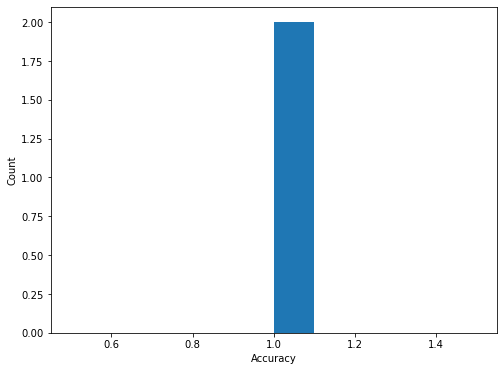

In [25]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

The histogram shown above indicates the difficulty of training a good model on the MUTAG dataset due to the following factors,
- small amount of available data, i.e., only 188 graphs
- small amount of validation data since for a single fold only 19 graphs are used for validation
- the data are unbalanced since the majority class is twice as prevalent in the data

Given the above, average performance as estimated using repeated 10-fold cross validation displays high variance but overall good performance for a straightforward application of graph convolutional neural networks to supervised graph classification. The high variance is likely the result of the small dataset size.

Generally, performance is a bit lower than SOTA in recent literature. However, we have not tuned the model for the best performance possible so some improvement over the current baseline may be attainable.

When comparing to graph kernel-based approaches, our straightforward GCN with mean pooling graph classification model is competitive with the WL kernel being the exception.

For comparison, some performance numbers repeated from [3] for graph kernel-based approaches are, 
- Graphlet Kernel (GK): $81.39\pm1.74$
- Random Walk Kernel (RW): $79.17\pm2.07$
- Propagation Kernel (PK): $76.00\pm2.69$
- Weisfeiler-Lehman Subtree Kernel (WL): $84.11\pm1.91$

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/graph-classification/gcn-supervised-graph-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/graph-classification/gcn-supervised-graph-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>